In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# creating a list of names
words = open('names.txt' , 'r').read().splitlines()
# len(words)

# building the dictionaries for character to integer mappings


chars = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i,s  in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
# building the inputs and the outputs for the MLP

block_size = 3 # No. of characters we want to provide as context

def build_dataset(words):

    X = []
    Y = []
    for w in words :
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print (X.shape , Y.shape)
    
    return X , Y

import random 
random.seed(47)
random.shuffle(words)

# train , test, cv split 

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9) 

X_train , Y_train = build_dataset(words[:n1]) # 80%

X_cv , Y_cv = build_dataset(words[n1:n2])     # 10%

X_test , Y_test = build_dataset(words[n2:])    # 10%

torch.Size([182501, 3]) torch.Size([182501])
torch.Size([22802, 3]) torch.Size([22802])
torch.Size([22843, 3]) torch.Size([22843])


In [67]:
# Building a deeper MLP with Py-Torch

class Linear:
    
    def __init__(self, fan_in , fan_out , bias = True):
        self.weights = torch.randn((fan_in, fan_out) , generator = g)/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self , x):
        self.out = x @ self.weights 
        if self.bias is not None:
            self.out += self.bias 
        return self.out 
    
    def parameters(self):
        return [self.weights] + ([ ] if not self.bias is None else [self.bias])
    
class BatchNorm1D:
    
    def __init__(self, dim , eps = 1e-5 , momentum = 0.1):
        self.eps = eps
        self.momentum = momentum 
        self.training = True
        
        # parameters to be trained using backprop 
        self.beta = torch.ones(dim)
        self.gamma = torch.zeros(dim)
        
        # parameters required by layer to allow calculation on a single input and to standardize
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # calculate the forward pass 
        if self.training:
            xmean = x.mean( 0 , keepdim = True) # batch mean
            xvar = x.var (0, keepdim = True) # batch std
        else :
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/(torch.sqrt(xvar + self.eps))
        
        self.out = self.beta * xhat + self.gamma 
        
        
        # updating the buffers 
        if self.training :
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + xmean * self.momentum
                self.running_var = (1- self.momentum) * self.running_var + xvar * self.momentum
        
        return self.out 
    
    def parameters (self):
        return [self.gamma , self.beta]
    
    
    
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters (self):
        return [ ]
    
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size , n_emb) , generator = g)

layers = [
    Linear(n_emb * block_size , n_hidden) , BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden , n_hidden) , BatchNorm1D(n_hidden),           Tanh(),
    Linear(n_hidden , n_hidden) , BatchNorm1D(n_hidden),           Tanh(),
    Linear(n_hidden , n_hidden) , BatchNorm1D(n_hidden),           Tanh(),
    Linear(n_hidden , n_hidden) , BatchNorm1D(n_hidden),           Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1D(vocab_size)         
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weights *= 0.1
    layers[-1].gamma += 0.1
    
    # all other layers: apply gain 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *=  5/3 
            
            # Without Batch Norm:
            # 1 won't be as good here because tanh is like a squashing layer and we need 
            # some gain to sort of try and offset that squashing ; but too much gain will saturate it towards 
            # -1 and 1.
            
            # With Batch Norm:
            # Varying will lead to somewhat similar activation and gradient distribution but the update ratio
            # will vary based on the chosen value and so to correct that we may need to modify the learning rate. 
            # But otherwise the system has become much more robust than before.

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [68]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.9270
  10000/ 200000: 2.4618
  20000/ 200000: 2.4698
  30000/ 200000: 2.2375
  40000/ 200000: 2.4281
  50000/ 200000: 2.2192
  60000/ 200000: 2.3386
  70000/ 200000: 1.9662
  80000/ 200000: 1.9592
  90000/ 200000: 1.8841
 100000/ 200000: 1.7693
 110000/ 200000: 2.0461
 120000/ 200000: 2.0037
 130000/ 200000: 2.1019
 140000/ 200000: 1.8549
 150000/ 200000: 2.2189
 160000/ 200000: 1.7880
 170000/ 200000: 2.1180
 180000/ 200000: 2.0925
 190000/ 200000: 2.0016


layer 2 (      Tanh): mean -0.00, std 0.70, saturated: 16.03%
layer 5 (      Tanh): mean -0.02, std 0.74, saturated: 18.88%
layer 8 (      Tanh): mean -0.02, std 0.77, saturated: 18.88%
layer 11 (      Tanh): mean +0.00, std 0.78, saturated: 20.59%
layer 14 (      Tanh): mean -0.03, std 0.80, saturated: 22.84%


Text(0.5, 1.0, 'activation distribution')

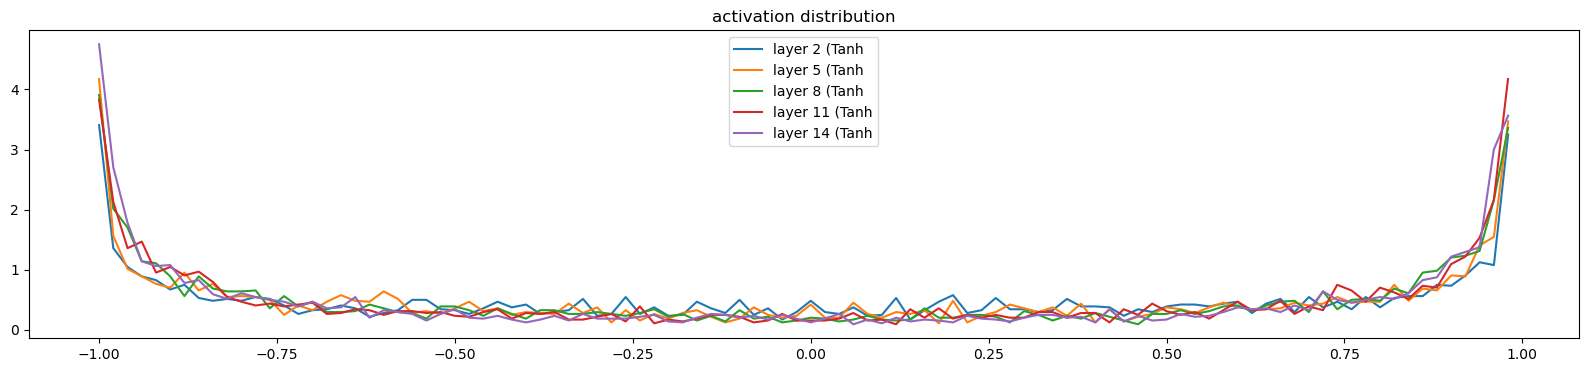

In [69]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


# More symmetry throughout the neural networks means more well behaved ; not diffusing or sharpening

layer 2 (      Tanh): mean -0.000000, std 4.492437e-03
layer 5 (      Tanh): mean +0.000000, std 4.145377e-03
layer 8 (      Tanh): mean +0.000000, std 3.930100e-03
layer 11 (      Tanh): mean -0.000000, std 3.562631e-03
layer 14 (      Tanh): mean -0.000000, std 3.860066e-03


Text(0.5, 1.0, 'gradient distribution')

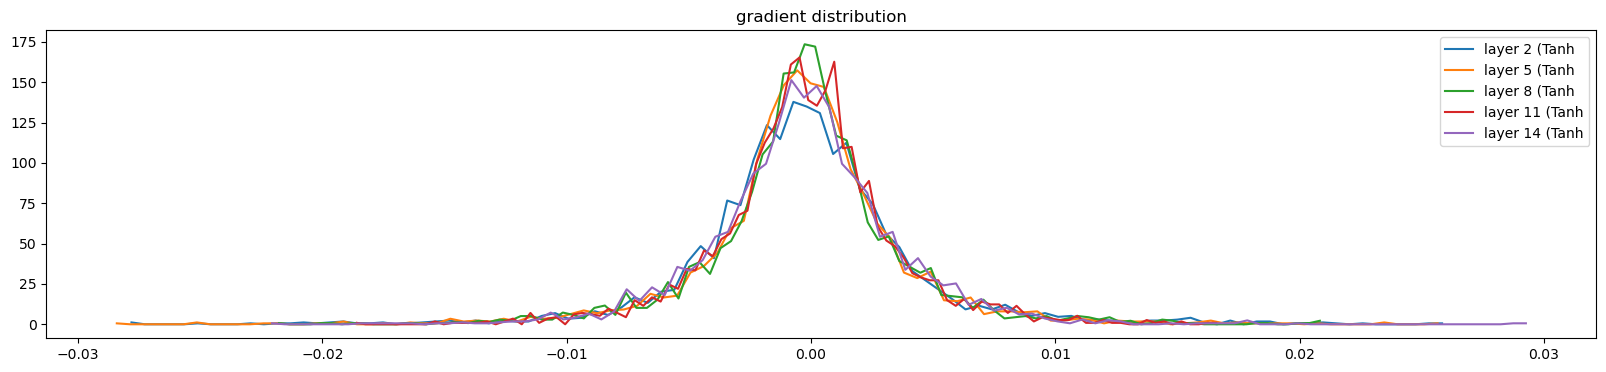

In [70]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.482128e-02 | grad:data ratio 1.291851e-02
weight  (30, 100) | mean +0.000129 | std 9.302827e-03 | grad:data ratio 2.068906e-02
weight (100, 100) | mean +0.000002 | std 6.160353e-03 | grad:data ratio 2.250524e-02
weight (100, 100) | mean -0.000093 | std 5.788551e-03 | grad:data ratio 2.150419e-02
weight (100, 100) | mean +0.000046 | std 5.428697e-03 | grad:data ratio 2.078794e-02
weight (100, 100) | mean -0.000071 | std 5.123558e-03 | grad:data ratio 2.042656e-02
weight  (100, 27) | mean -0.000011 | std 9.458611e-03 | grad:data ratio 2.527515e-02


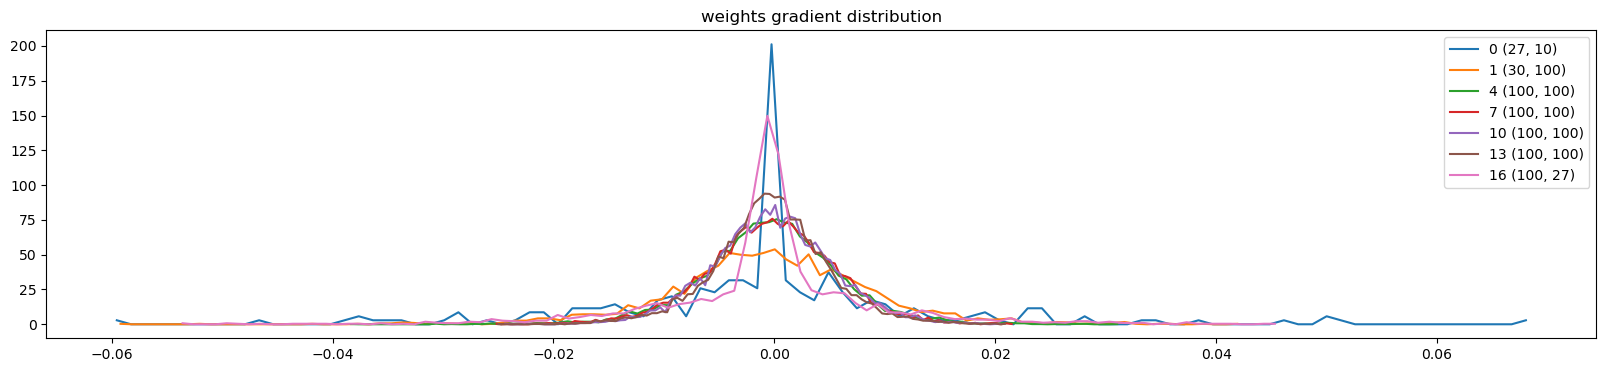

In [71]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


# If the gradient is too large in comparison to the data then we know that it will massively impact the value after
# the update is made and so here we will have to play with the learning rate a bit.

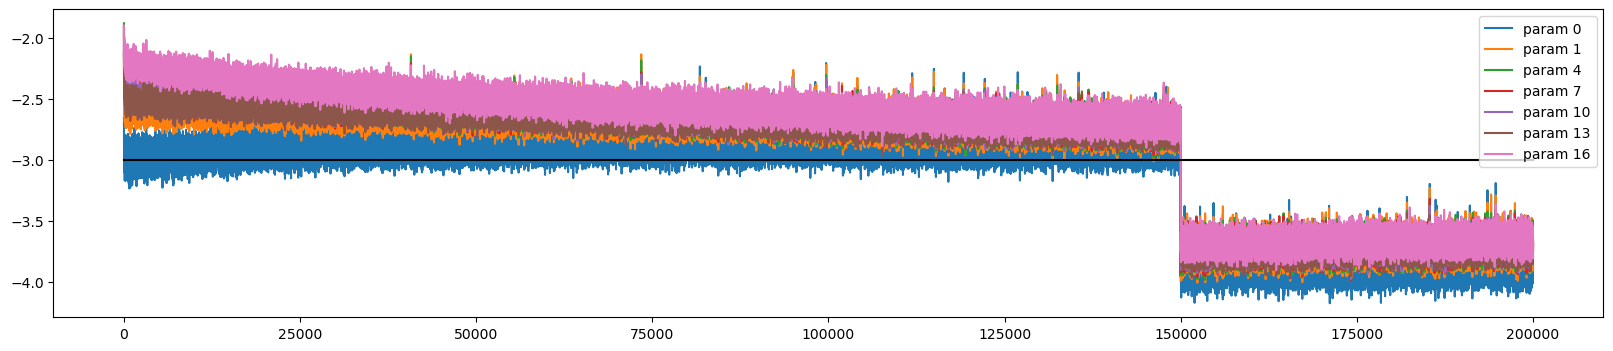

In [72]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# The last layer initially shows a higher change because we artifically multiplied it's weights by 0.1 to 
# make it less confident.

# This plot also tells us somewhat what we should keep our learning rate as to keep changes in range.

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (X_train, Y_train),
    'val': (X_cv, Y_cv),
    'test': (X_test, Y_test),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
    
    
split_loss('train')
split_loss('val')

train 2.4156699180603027
val 2.4049296379089355


In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpah.
qtorilel.
kimrix.
thty.
salaylae.
mahnen.
del.
archiaeli.
nelenia.
chaiiv.
kalein.
dhlm.
join.
qhiltharlin.
alia.
biio.
jelo.
dearyxi.
jayeelinra.
med.
